# 1.Import Data

In [1]:
import numpy as np
import pickle
import sklearn
import tensorflow as tf
from tqdm import tqdm

In [2]:
# function for loading pickle file
def loadPickle(file_name):
    picklefile = open('.\\DataSet\\'+file_name+".pkl",mode="rb")
    data = pickle.load(picklefile)
    picklefile.close()
    return data

In [3]:
y_train = loadPickle('y_train')
y_test = loadPickle('y_test')
X_train = loadPickle('X_train_vec')
X_test = loadPickle('X_test_vec')

# 2. Preprocessing for padding the matrix to same size
## 2.1. Get Max Length of Rows in X

In [4]:
# increase the length of each text in each row till it matches the max length of all the texts
def getlenMax(input_data):
    'function for estimating the max length of text in data'
    max_no = 0
    for text in input_data:
        num_word = len(text)
        if max_no <= num_word:
            max_no = num_word

    return max_no

def compare(train,test):
    'function for comparison between test and train'
    no_train = getlenMax(train)
    no_test = getlenMax(test)
    if no_train > no_test:
        return no_train
    else:
        return no_test

In [5]:
max_len = compare(X_train,X_test)
print(max_len) # get the max length of rows in X

4327


## 2.2. Padding the format
#### because LSTM is time-series model, pre-padding make more sense

In [6]:
def extendText(input_data, len_max,padding="pre",dimension=300):
    content=list()
    if padding == "post":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((text,x))#padding is post
            content.append(new_text)
            
    elif padding == "pre":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((x,text))#padding is pre
            content.append(new_text)

    content = np.array(content)
    return content

In [7]:
test = [[[1,2,3],[3,4,5]],[[1,2,3],[4,5,6]]]
test = np.array(test)
test = extendText(test,max_len,dimension=3)
print(test)
print(len(test[0]))

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2035.58it/s]

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [1. 2. 3.]
  [3. 4. 5.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [1. 2. 3.]
  [4. 5. 6.]]]
4327


In [8]:
X_train = extendText(X_train,max_len)
X_test = extendText(X_test,max_len)

100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 191.49it/s]


# 3. Build BiLSTM
## 3.1. Initialize the Model and Add the Layers

In [9]:
# import libraries
import keras
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Bidirectional
from keras_self_attention import SeqSelfAttention

In [23]:
# firstly we need to make sure our input share the same format
input_shape = X_train[0].shape
print(input_shape) # this means 300 length vectors with 162 timesteps

(4327, 300)


In [70]:
def modelBuild(input_shape):
    # initialize model
    model = keras.Sequential()
    
    # add 1st BiLSTM layer, I need to set the input_shape directly, 
    # which should be 2 dimensions, one for the timesteps, one for the indicators inside
    # because sentence can be complex, here I should set the LSTM cells number as 50, but in order to lower the consuming time, I only set 5
    forward_layer = LSTM(units = 5, activation="tanh",dropout=0.2, recurrent_activation="sigmoid", return_sequences = True)
    #backward_layer = LSTM(units = 10, activation='relu',dropout=0.2, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(layer = forward_layer,merge_mode="concat",input_shape = input_shape))
    
    forward_layer2 = LSTM(units = 5, activation="tanh",dropout=0.2, recurrent_activation="sigmoid")
    # add 2nd LSTM layer
    model.add(Bidirectional(layer = forward_layer2))
    
   
    # add output layer, since the data has 2 output [0,1] as label, I set the final neurons number as 1
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

## 3.2. Compilation

In [71]:
model = modelBuild(input_shape)

In [72]:
# compilation
# we use stochastic gradient descent as our optimizer, cross entropy as our loss function
# it's because I use integer binary result [0,1] as label, so I use binary crossentropy as my loss function
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [73]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_17 (Bidirectio (None, 4327, 10)          12240     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 10)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 12,891
Trainable params: 12,891
Non-trainable params: 0
_________________________________________________________________


## 3.3. Function for Storage of Model

In [74]:
# global parameter
modelname="BiLSTM"

In [75]:
def saveModel(model,modelname):
    model_json=model.to_json()
    # specialize model to json
    name_path = "DataSet\\{a}".format(a=modelname)
    with open(name_path+".json","w") as json_file:
        json_file.write(model_json)
        
    # sepcialize weights to HDF5
    model.save_weights(name_path+".h5")
    print("Save model to DataSet archive successfully")

# 4. Train Model

In [78]:
epochs = 20
batch = 50
vali_split=0.1
# though validation_data is not used in propagation, the model will be gradually familier with validation data. There can be information leak.
# therefore, normally use validation_split for testing model to avoid overfitting

In [79]:
history = model.fit(x = X_train,y=y_train,validation_split=vali_split, epochs =epochs, batch_size=batch)
saveModel(model,modelname)

Epoch 1/2
26/26 [==============================] - 400s 15s/step - loss: 0.1808 - accuracy: 0.9604 - val_loss: 0.1888 - val_accuracy: 0.9362
Epoch 2/2
26/26 [==============================] - 396s 15s/step - loss: 0.1839 - accuracy: 0.9541 - val_loss: 0.1279 - val_accuracy: 0.9787
Save model to DataSet archive successfully


# 5. Load Model

In [80]:
def loadModel(modelname):
    # load json file
    load_path = ".\\DataSet\\{a}".format(a=modelname)
    json_file = open(load_path+".json",'r')
    model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(model_json)
    # load weights and assign them to the model
    model.load_weights(load_path+".h5")
    print("loaded {a} model successfully".format(a=modelname))
    
    return model

In [81]:
model = loadModel(modelname)

loaded BiLSTM model successfully


# 6. Prediction

In [83]:
y_possible = model.predict(X_test)

In [94]:
y_possible

array([[0.10358465],
       [0.06755954],
       [0.9180702 ],
       [0.06812197],
       [0.06392232],
       [0.9138226 ],
       [0.90771556],
       [0.06397974],
       [0.91055924],
       [0.23385051],
       [0.08206993],
       [0.06761158],
       [0.07469389],
       [0.9126676 ],
       [0.07746908],
       [0.81029975],
       [0.9223196 ],
       [0.9119033 ],
       [0.06703079],
       [0.9151062 ],
       [0.9146739 ],
       [0.06371745],
       [0.92194164],
       [0.91214734],
       [0.90737927],
       [0.07862231],
       [0.90914696],
       [0.9078839 ],
       [0.07295573],
       [0.92110795],
       [0.8372765 ],
       [0.06826371],
       [0.06576926],
       [0.9202039 ],
       [0.07906097],
       [0.07047924],
       [0.88317025],
       [0.9201918 ],
       [0.09170637],
       [0.913594  ],
       [0.9127896 ],
       [0.06419018],
       [0.07280502],
       [0.9101367 ],
       [0.91424334],
       [0.07799736],
       [0.08485469],
       [0.172

In [95]:
def setResult(y_possible,standard):
    y_preds = list()
    for each in y_possible:
        if each >= standard:
            y_preds.append(1)
        else:
            y_preds.append(0)
    y_preds=np.array(y_preds)
    return y_preds

In [96]:
y_preds=setResult(y_possible,standard=0.5)

In [97]:
y_preds

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,

# 7.Evaluation
## 7.1. Learning Curve

In [98]:
import matplotlib.pyplot as plt

def plot_learningCurve(history,epochs,modelname):
    epoch_range = range(1, epochs +1)
    plt.figure()
    plt.plot(epoch_range,history.history['accuracy'],color='b',label='accuracy')
    plt.plot(epoch_range,history.history['val_accuracy'],color='r',label='validation accuracy')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('History of {a} Model Accuracy'.format(a=modelname))
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\History of {a} Model Accuracy.png".format(a=modelname))
    plt.show()
    
    plt.figure()
    plt.plot(epoch_range,history.history['loss'],color='b',label='loss')
    plt.plot(epoch_range,history.history['val_loss'],color='r',label='validation loss')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('History of {a} Model Loss'.format(a=modelname))
    plt.legend(loc="upper left")
    plt.savefig("Pictures\\History of {a} Model Loss.png".format(a=modelname))
    plt.show()

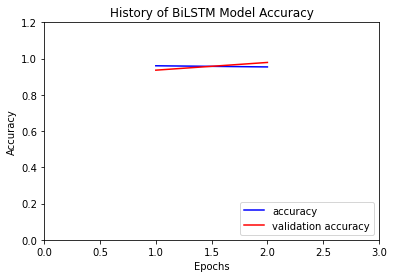

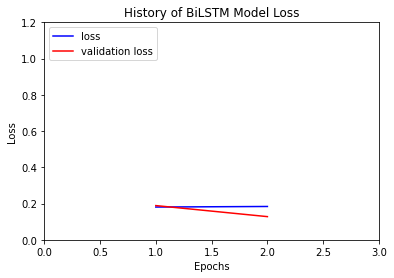

In [99]:
plot_learningCurve(history,epochs,modelname)

## 7.2. F1 Score and Other Measures 

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def getEvaluation(y_test,y_pred,X_test, model):
    ev = dict()
    ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision"]=precision_score(y_test,y_pred,average="binary")
    ev["recall"]=recall_score(y_test,y_pred,average="binary")
    ev["F1 score"]=f1_score(y_test,y_pred,average="binary")
    
    for key in ev.keys():
        if key !="confusion_matrix":
            print("{a} is: {b}".format(a=key, b=ev[key]))
        else:
            print(ev[key])
    
    # and also the basic evaluation from keras
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    eval_ = model.evaluate(X_test,y_test)
    print("Loss: {0:.7}".format(eval_[0]))
    print("Accuracy: {0:.2%}".format(eval_[1]))
    
    return ev

In [103]:
ev = getEvaluation(y_test,y_preds,X_test,model)

[[171  14]
 [  7 159]]
accuracy is: 0.9401709401709402
precision is: 0.9190751445086706
recall is: 0.9578313253012049
F1 score is: 0.9380530973451328
11/11 [==============================] - 31s 3s/step - loss: 0.2057 - accuracy: 0.9402
Loss: 0.2057349
Accuracy: 94.02%
